# Configs

In [ ]:
config = {
    'model_id': 'mistralai/Mistral-7B-v0.1',
    'sequence_id': 'facet-5',
    'text_sequence': "Section 25F of Industrial Disputes Act: No workman employed in any industry who has been in continuous service for not less than one year under an employer shall be retrenched by that employer until"
}
safe_model_id = config['model_id'].replace('/', '')
safe_sequence_id = config['sequence_id'].replace('/', '')

# Installs and Secrets

In [ ]:
!pip install -U bertviz -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 118.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, utils
import numpy as np
import torch

In [ ]:
hf_token = ''

# Helper Functions
From https://github.com/jessevig/bertviz/blob/master/bertviz/util.py, as implemented in Vig (2019), [A Multiscale Visualization of Attention in the Transformer Model](https://aclanthology.org/P19-3007.pdf) (ACL System Demonstrations 2019).

In [ ]:
def num_layers(attention):
    return len(attention)


def num_heads(attention):
    return attention[0][0].size(0)


def format_special_chars(tokens):
    return [t.replace('Ġ', ' ').replace('▁', ' ').replace('</w>', '') for t in tokens]


def format_attention(attention, layers=None, heads=None): # takes a set of attention matrices (one per layer), removes the batch dimension (if it exists), and then stacks them into a single tensor with shape (num_layers, num_heads, seq_len, seq_len)
    if layers:
        attention = [attention[layer_index] for layer_index in layers]
    squeezed = []
    for layer_attention in attention:
        # 1 x num_heads x seq_len x seq_len
        if len(layer_attention.shape) != 4:
            raise ValueError("The attention tensor does not have the correct number of dimensions. Make sure you set "
                             "output_attentions=True when initializing your model.")
        layer_attention = layer_attention.squeeze(0)
        if heads:
            layer_attention = layer_attention[heads]
        squeezed.append(layer_attention)
    # num_layers x num_heads x seq_len x seq_len
    return torch.stack(squeezed)

# Instantiate Model and Components

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(config['model_id'], use_auth_token=hf_token)
model = AutoModelForCausalLM.from_pretrained(config['model_id'], output_attentions=True, use_auth_token=hf_token)

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/tokenization_auto.py:786: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/auto_factory.py:469: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

# Forward Pass on the Text Sequence

In [ ]:
text_sequence = config['text_sequence']
inputs = tokenizer.encode(text_sequence, return_tensors='pt')              # Converts the text_sequence into token IDs and returns them as a PyTorch tensor.
outputs = model(inputs)                                                    # This is used for forward passes through the model, typically when you want to obtain the raw output logits or hidden states from the model, not for generating text, which uses model.generate().
attention_matrices = format_attention(outputs[-1])                         # Obtain the stacked attention matrices (one for each layer)
output_tokens = tokenizer.convert_ids_to_tokens(inputs[0])                 # Converts the token IDs back into their corresponding token strings. Output: ['<s>', '▁Question', ':', '▁What', '▁is', '▁the', '_time', '?']

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)
MistralModel is using MistralSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


In [ ]:
print(f"Model Output Tokens: {output_tokens}\n")
print(f"Model Output Sequence Length: {len(output_tokens)}\n")
print(f"Model Attention Matrices: {type(attention_matrices)} of shape {attention_matrices.shape}\n")
print("Preview of attention scores in layer 0 head 0:\n")
print(attention_matrices[0][0])

Model Output Tokens: ['<s>', '▁Section', '▁', '2', '5', 'F', '▁of', '▁Industrial', '▁Dis', 'put', 'es', '▁Act', ':', '▁No', '▁work', 'man', '▁employed', '▁in', '▁any', '▁industry', '▁who', '▁has', '▁been', '▁in', '▁continuous', '▁service', '▁for', '▁not', '▁less', '▁than', '▁one', '▁year', '▁under', '▁an', '▁employer', '▁shall', '▁be', '▁ret', 'ren', 'ched', '▁by', '▁that', '▁employer', '▁until']

Model Output Sequence Length: 44

Model Attention Matrices: <class 'torch.Tensor'> of shape torch.Size([32, 32, 44, 44])

Preview of attention scores in layer 0 head 0:

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.9663e-01, 3.3679e-03, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.5568e-01, 2.7310e-03, 4.1587e-02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [8.5125e-01, 9.6464e-04, 8.3445e-03,  ..., 2.7488e-02, 0.0000e+00,
         0.0000e+00],
        [8.9823e-01, 9.4603e

### Save raw attention matrices

In [ ]:
np.save(f'{safe_sequence_id}_{safe_model_id}_attentions_raw.npy', attention_matrices.detach().numpy())

# Exclude attention of tokens of low semantic importance, such as special tokens

### Inspect Model Output Tokens

In [1]:
print(f"Model Output Tokens: {output_tokens}\n")

NameError: name 'output_tokens' is not defined

### Specify tokens to be excluded

In [ ]:
tokens_to_exclude = ['<s>', '▁', '(', ')', ':', '▁...', ',', '-']

### Identify indices of excluded tokens in the token sequence

In [ ]:
indices_of_tokens_to_exclude = [i for i, token in enumerate(output_tokens) if token in tokens_to_exclude]
number_of_tokens_to_exclude = sum(output_tokens.count(token) for token in tokens_to_exclude)
print(indices_of_tokens_to_exclude)
assert len(indices_of_tokens_to_exclude) == number_of_tokens_to_exclude, "Number of indices retrieved does not match number of tokens to exclude."

[0, 2, 12]


### Reset attention scores of excluded token indices to 0

In [2]:
attention_matrices_filtered = attention_matrices.clone()

for idx in indices_of_tokens_to_exclude:
    attention_matrices_filtered[:, :, :, idx] = 0  # Setting attention for excluded tokens across all layers and heads

print(f"Filtered attention matrix of layer 0, head 0:\n")
print(attention_matrices_filtered[0][0])

NameError: name 'attention_matrices' is not defined

### Save filtered attention matrices

In [ ]:
np.save(f'{safe_sequence_id}_{safe_model_id}_attentions_filtered.npy', attention_matrices_filtered.detach().numpy())

# Compute proportion of filtered attention given to tokens representing legal facets

### Inspect Tokens

In [ ]:
print(f"Model Output Tokens: {output_tokens}\n")

Model Output Tokens: ['<s>', '▁Section', '▁', '2', '5', 'F', '▁of', '▁Industrial', '▁Dis', 'put', 'es', '▁Act', ':', '▁No', '▁work', 'man', '▁employed', '▁in', '▁any', '▁industry', '▁who', '▁has', '▁been', '▁in', '▁continuous', '▁service', '▁for', '▁not', '▁less', '▁than', '▁one', '▁year', '▁under', '▁an', '▁employer', '▁shall', '▁be', '▁ret', 'ren', 'ched', '▁by', '▁that', '▁employer', '▁until']



### Specify tokens of indices representing legal facets

In [ ]:
tokens_to_compute = ['▁who', '▁has', '▁been', '▁in', '▁continuous', '▁service', '▁for', '▁not', '▁less', '▁than', '▁one', '▁year', '▁under', '▁an', '▁employer']

In [ ]:
indices_of_tokens_to_compute = [i for i, token in enumerate(output_tokens) if token in tokens_to_compute]
number_of_tokens_to_compute = sum(output_tokens.count(token) for token in tokens_to_compute)
print(indices_of_tokens_to_compute)
# assert len(indices_of_tokens_to_compute) == number_of_tokens_to_compute, "Number of indices retrieved does not match number of tokens to exclude."
indices_of_tokens_to_compute = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
print(indices_of_tokens_to_compute)

[17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 42]
[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


### Compute proportion of attention given to specified token indices

In [ ]:
num_layers, num_heads, seq_len, _ = attention_matrices_filtered.shape

# Step 1: Create an empty NumPy array to store the proportion for each layer and head
proportion_matrix = np.zeros((num_layers, num_heads))

# Iterate over each layer and each head
for layer in range(num_layers):
    for head in range(num_heads):
        # Step 2: Extract the attention matrix for the current layer and head
        current_attention = attention_matrices_filtered[layer][head]

        # Step 3: Sum the attention directed to the indices of interest
        attention_sum_indices = current_attention[:, indices_of_tokens_to_compute].sum().item()

        # Step 4: Sum all the attention values for the current head
        total_attention_sum = current_attention.sum().item()

        # Step 5: Compute the proportion of attention to the indices of interest
        proportion = attention_sum_indices / total_attention_sum

        # Step 6: Store the proportion in the NumPy proportion matrix
        proportion_matrix[layer, head] = proportion

### Save proportion matrix to local

In [ ]:
np.save(f'{safe_sequence_id}_{safe_model_id}_proportions.npy', proportion_matrix)

# Compare proportion of attention given to token indices across Mistral-7B-v0.1, SaulLM-7B, and SaulLM-7B-Instruct

### Load the proportion matrices of each model

In [ ]:
proportions_mistral = np.load('facet-1_mistral-7b-v0.1_proportions.npy')
proportions_saul = np.load('facet-1_saul-7b_proportions.npy')
proportions_saul_instruct = np.load('facet-1_saul-7b-instruct_proportions.npy')

### Visualize proportion matrix

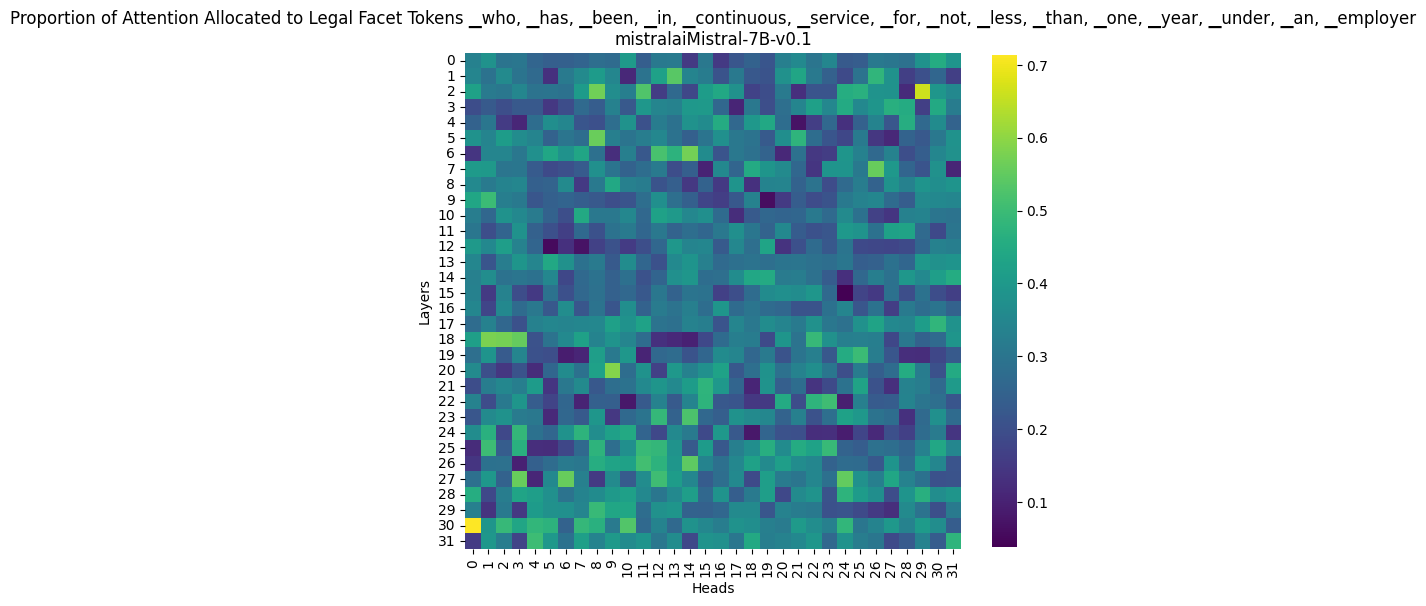

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'proportion_matrix' is already a NumPy array
# Example proportion_matrix (replace this with the actual one from the code above)
# proportion_matrix = np.array(...)

# Step 1: Create a heatmap using seaborn
plt.figure(figsize=(8, 8))  # Set the figure size to make it square
sns.heatmap(proportion_matrix, annot=False, fmt=".2f", cmap='viridis', square=True, cbar_kws={"shrink": .8})

# Step 2: Set labels and title
plt.title(f"Proportion of Attention Allocated to Legal Facet Tokens {', '.join(tokens_to_compute)}\n{safe_model_id}")
plt.xlabel('Heads')
plt.ylabel('Layers')

# Step 3: Show the heatmap
plt.show()
